In [1]:
# 第一部分  数据获取
import requests
import tushare as ts
import json # json对str格式太严格了
import pandas as pd

# 第1步 获取上证50成分股列表,和总股本、流通股本
cookies = {
    'qgqp_b_id': '4f3cb9c1bb8620aa43690b9ef7bbd709',
    'st_si': '10069033681415',
    'em_hq_fls': 'js',
    'cowCookie': 'true',
    'intellpositionL': '474px',
    'cowminicookie': 'true',
    '_qddaz': 'QD.699ajn.btcixj.kqyo9whm',
    'st_asi': 'delete',
    'HAList': 'f-0-000016-%u4E0A%u8BC150%2Ca-sh-603986-%u5146%u6613%u521B%u65B0%2Cf-0-000001-%u4E0A%u8BC1%u6307%u6570%2Cf-0-399001-%u6DF1%u8BC1%u6210%u6307%2Ca-sz-002059-%u4E91%u5357%u65C5%u6E38',
    'st_pvi': '84987597711115',
    'st_sp': '2021-04-28%2017%3A23%3A15',
    'st_inirUrl': 'https%3A%2F%2Fwww.baidu.com%2Flink',
    'st_sn': '158',
    'st_psi': '20210711212150244-113300300812-5815487727',
    'intellpositionT': '878px',
}

headers = {
    'Connection': 'keep-alive',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': '*/*',
    'Referer': 'http://data.eastmoney.com/',
    'Accept-Language': 'zh-CN,zh;q=0.9',
}

params = (
    #('cb', 'jQuery1123014460896686369185_1626009753301'),
    ('st', '1'),
    ('sr', '-1'),
    ('ps', '50'),
    ('p', '1'),
    ('type', 'SHSZZS'),
    ('sty', 'SHSZZS'),
    ('js', '{"data":[(x)]}'),
    #('js', '({"data":[(x)],"pages":(pc)})'),
    ('token', '894050c76af8597a853f5b408b759f5d'),
    ('code', '000016'),
) 
 
response = requests.get('http://datainterface.eastmoney.com/EM_DataCenter/js.aspx', headers=headers, params=params, cookies=cookies, verify=False)

#NB. Original query string below. It seems impossible to parse and
#reproduce query strings 100% accurately so the one below is given
#in case the reproduced version is not "correct".
# response = requests.get('http://datainterface.eastmoney.com/EM_DataCenter/js.aspx?cb=jQuery1123014460896686369185_1626009753301&st=1&sr=-1&ps=50&p=1&type=SHSZZS&sty=SHSZZS&js=(%7B%22data%22%3A%5B(x)%5D%2C%22pages%22%3A(pc)%7D)&token=894050c76af8597a853f5b408b759f5d&code=000016', headers=headers, cookies=cookies, verify=False)

In [2]:
# 得到有效数据并转换为json格式
response.text
json_flu = json.loads(response.text)['data']

# 处理列表数据 变为易处理的 dataframe 
list2d = [i.split(',') for i in json_flu]
df = pd.DataFrame(list2d)
chart = ['股票代码', '股票简称', '主营行业', '地区', '每股收益（元）', '每股净资产（元）', '净资产收益率（%）','总股本（亿股）','流通股本（亿股）','最新价（元）','流通市值（亿元）','00','权重(%)','sz50','更新时间','price','22','33','44']
df.columns = chart
df_use = df[['股票代码','股票简称','更新时间','总股本（亿股）','流通股本（亿股）','最新价（元）','流通市值（亿元）','权重(%)']]

# 将dataframe 里str数据转换为float
df_float = df_use.astype({'总股本（亿股）':'float','流通股本（亿股）':'float','权重(%)':'float','流通市值（亿元）':'float','最新价（元）':'float'})
df_float.head(4)

,股票代码,股票简称,更新时间,总股本（亿股）,流通股本（亿股）,最新价（元）,流通市值（亿元）,权重(%)
0,603986,兆易创新,2021-07-15,6.643151,6.152364,173.83,1069.465389,1.194578
1,603501,韦尔股份,2021-07-15,8.685808,7.854500,320.38,2516.424566,2.163412
2,603288,海天味业,2021-07-15,42.125762,42.125762,128.49,5412.739121,2.027769
3,603259,药明康德,2021-07-15,29.521578,29.346142,165.00,4201.289745,3.716255


In [3]:
# 第2步 计算成分股自由流通比例  认为其短期为定值

df_float['自由流通比例'] = df_float['流通股本（亿股）']/df_float['总股本（亿股）']
df_float.head(4)

,股票代码,股票简称,更新时间,总股本（亿股）,流通股本（亿股）,最新价（元）,流通市值（亿元）,权重(%),自由流通比例
0,603986,兆易创新,2021-07-15,6.643151,6.152364,173.83,1069.465389,1.194578,0.926121
1,603501,韦尔股份,2021-07-15,8.685808,7.854500,320.38,2516.424566,2.163412,0.904291
2,603288,海天味业,2021-07-15,42.125762,42.125762,128.49,5412.739121,2.027769,1.000000
3,603259,药明康德,2021-07-15,29.521578,29.346142,165.00,4201.289745,3.716255,0.994057


In [5]:
# 第3步 计算成分股加权比例

import math
def get_val(value):
    if value > 0.8:
        return 1
    elif value > 0.7:
        return 0.8
    elif value > 0.6:
        return 0.7
    elif value > 0.5:
        return 0.6
    elif value > 0.4:
        return 0.5
    elif value > 0.3:
        return 0.4
    elif value > 0.2:
        return 0.3
    elif value > 0.15:
        return 0.2
    elif value > 0.0:
        return 100 * math.ceil(value*100)
    else:
        print('value error')

df_float['加权比例'] = df_float.apply(lambda x: get_val(x.自由流通比例),axis = 1)
df_float.head(4)

,股票代码,股票简称,更新时间,总股本（亿股）,流通股本（亿股）,最新价（元）,流通市值（亿元）,权重(%),自由流通比例,加权比例
0,603986,兆易创新,2021-07-15,6.643151,6.152364,173.83,1069.465389,1.194578,0.926121,1.0
1,603501,韦尔股份,2021-07-15,8.685808,7.854500,320.38,2516.424566,2.163412,0.904291,1.0
2,603288,海天味业,2021-07-15,42.125762,42.125762,128.49,5412.739121,2.027769,1.000000,1.0
3,603259,药明康德,2021-07-15,29.521578,29.346142,165.00,4201.289745,3.716255,0.994057,1.0


In [6]:
# 第4步 计算调整股本

df_float['调整股本'] = df_float['加权比例'] * df_float['总股本（亿股）']
df_float.head(4)

,股票代码,股票简称,更新时间,总股本（亿股）,流通股本（亿股）,最新价（元）,流通市值（亿元）,权重(%),自由流通比例,加权比例,调整股本
0,603986,兆易创新,2021-07-15,6.643151,6.152364,173.83,1069.465389,1.194578,0.926121,1.0,6.643151
1,603501,韦尔股份,2021-07-15,8.685808,7.854500,320.38,2516.424566,2.163412,0.904291,1.0,8.685808
2,603288,海天味业,2021-07-15,42.125762,42.125762,128.49,5412.739121,2.027769,1.000000,1.0,42.125762
3,603259,药明康德,2021-07-15,29.521578,29.346142,165.00,4201.289745,3.716255,0.994057,1.0,29.521578


In [7]:
# 第二部分 爬取上证50指数成分股日收盘价 0615-0715  22天

# 第1步 爬取成分股每日收盘价
list_code50 = df_float['股票代码']
data50 = pd.DataFrame()
for i in list_code50: 
    data50 = data50.append( ts.get_k_data(i,'2021-06-15','2021-07-15') )

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
本接口即将停止更新，请尽

In [8]:
data50.head(40)

,date,open,close,high,low,volume,code
106,2021-06-15,141.00,137.87,145.25,137.00,153919.0,603986
107,2021-06-16,139.37,135.27,143.56,134.98,179991.0,603986
108,2021-06-17,136.35,148.80,148.80,136.33,254915.0,603986
109,2021-06-18,153.00,158.00,159.98,152.62,376808.0,603986
110,2021-06-21,158.00,158.88,161.88,154.90,218855.0,603986
111,2021-06-22,159.99,165.26,167.00,156.39,256650.0,603986
112,2021-06-23,163.09,173.15,179.50,162.03,328876.0,603986
113,2021-06-24,171.50,172.94,174.89,168.15,184935.0,603986
114,2021-06-25,172.00,171.00,174.50,165.01,183341.0,603986
115,2021-06-28,171.00,178.58,182.90,170.87,199823.0,603986


In [14]:
# 仅取收盘价等有用参数

data = data50[['date','code','close']]
data.head(4)

,date,code,close
106,2021-06-15,603986,137.87
107,2021-06-16,603986,135.27
108,2021-06-17,603986,148.80
109,2021-06-18,603986,158.00


In [15]:
# 第三部分 计算总调整市值 
# 第1步 将收盘价和调整股本合到一组 dataframe里

data['调整股本'] = data['code']

# 将 df_float 一列变为list类型
list_code  = df_float['股票代码'].tolist()
list_price = df_float['调整股本'].tolist()

data['调整股本'].replace(list_code, list_price, inplace=True)

<ipython-input-15-87b76d569161>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['调整股本'] = data['code']
C:\Users\surface\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [16]:
data.head(40) #data.tail()

,date,code,close,调整股本
106,2021-06-15,603986,137.87,6.643151
107,2021-06-16,603986,135.27,6.643151
108,2021-06-17,603986,148.80,6.643151
109,2021-06-18,603986,158.00,6.643151
110,2021-06-21,603986,158.88,6.643151
111,2021-06-22,603986,165.26,6.643151
112,2021-06-23,603986,173.15,6.643151
113,2021-06-24,603986,172.94,6.643151
114,2021-06-25,603986,171.00,6.643151
115,2021-06-28,603986,178.58,6.643151


In [17]:
# 第2步 计算每一支成分股每一天的调整市值
data['调整市值'] = data['调整股本'] * data['close']

<ipython-input-17-af0b5c97156d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['调整市值'] = data['调整股本'] * data['close']


In [39]:
data.head(60)

,date,code,close,调整股本,调整市值
106,2021-06-15,603986,137.87,6.643151,915.891238
107,2021-06-16,603986,135.27,6.643151,898.619045
108,2021-06-17,603986,148.80,6.643151,988.500879
109,2021-06-18,603986,158.00,6.643151,1049.617869
110,2021-06-21,603986,158.88,6.643151,1055.463842
111,2021-06-22,603986,165.26,6.643151,1097.847146
112,2021-06-23,603986,173.15,6.643151,1150.261608
113,2021-06-24,603986,172.94,6.643151,1148.866546
114,2021-06-25,603986,171.00,6.643151,1135.978833
115,2021-06-28,603986,178.58,6.643151,1186.333918


In [79]:
# 第3步 求上证50不同日期的总调整市值

list_value = list()
for i in range(106,127+1):
    total_market_value = data['调整市值'][i]
    #print(total_market_value)
    list_value.append( total_market_value.sum() )

In [80]:
print(list_value)

[206582.2643173406, 205126.31094518726, 203893.97607553896, 202362.8229267866, 200957.52713620468, 203110.35545447344, 201262.41868098397, 202106.0123058689, 204752.96160561632, 203585.89372255333, 201246.96579654692, 201882.62963494554, 203109.74191456276, 196964.72362575305, 195265.52568148493, 194920.7081467501, 195107.00521728993, 192196.13855824395, 191358.68884151755, 191459.36844269212, 192245.54874039566, 189544.3817784764]


In [81]:
list_value.reverse()
print(list_value)

[189544.3817784764, 192245.54874039566, 191459.36844269212, 191358.68884151755, 192196.13855824395, 195107.00521728993, 194920.7081467501, 195265.52568148493, 196964.72362575305, 203109.74191456276, 201882.62963494554, 201246.96579654692, 203585.89372255333, 204752.96160561632, 202106.0123058689, 201262.41868098397, 203110.35545447344, 200957.52713620468, 202362.8229267866, 203893.97607553896, 205126.31094518726, 206582.2643173406]


In [70]:
# 第3步 获取0615日的除数

index0615 = 3528.67
adj_price = 206582.2643173406
basic_point = 1000
chushu = basic_point * adj_price / index0615

In [71]:
# 第4步 获取上证50历史日收盘实际指数 实际前面数据仅取到14号

sz50_index0 = ts.get_hist_data('sz50',start='2021-06-15',end='2021-07-14')
sz50_index  = sz50_index0.drop(['open','high','low','p_change','price_change','ma5','ma10','ma20','v_ma5','v_ma10','v_ma20'],axis = 1)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [72]:
sz50_index

,close,volume
date,,
2021-07-14,3339.38,347336.75
2021-07-13,3391.74,314076.75
2021-07-12,3384.51,384163.19
2021-07-09,3361.59,316366.06
2021-07-08,3373.26,338624.53
2021-07-07,3424.39,269194.59
2021-07-06,3405.28,292118.34
2021-07-05,3404.79,309267.94
2021-07-02,3408.24,347108.62


In [73]:

print(type(list_value))

<class 'list'>


In [82]:
# 第5步 导入每天旧除数

sz50_index['总调整市值'] = list_value
sz50_index['旧总调整市值'] = sz50_index['总调整市值']
sz50_index

,close,volume,总调整市值,旧总调整市值
date,,,,
2021-07-14,3339.38,347336.75,189544.381778,189544.381778
2021-07-13,3391.74,314076.75,192245.548740,192245.548740
2021-07-12,3384.51,384163.19,191459.368443,191459.368443
2021-07-09,3361.59,316366.06,191358.688842,191358.688842
2021-07-08,3373.26,338624.53,192196.138558,192196.138558
2021-07-07,3424.39,269194.59,195107.005217,195107.005217
2021-07-06,3405.28,292118.34,194920.708147,194920.708147
2021-07-05,3404.79,309267.94,195265.525681,195265.525681
2021-07-02,3408.24,347108.62,196964.723626,196964.723626


In [83]:
# 第6步 计算 旧总调整市值/总调整市值 约等于
#print( type(index_cal) )
for n in range( len(sz50_index)-1 ):
    sz50_index['旧总调整市值'][n] = sz50_index['总调整市值'][n+1]
    
sz50_index['old_new'] = sz50_index['旧总调整市值'] / sz50_index['总调整市值']
sz50_index

,close,volume,总调整市值,旧总调整市值,old_new
date,,,,,
2021-07-14,3339.38,347336.75,189544.381778,192245.548740,1.014251
2021-07-13,3391.74,314076.75,192245.548740,191459.368443,0.995911
2021-07-12,3384.51,384163.19,191459.368443,191358.688842,0.999474
2021-07-09,3361.59,316366.06,191358.688842,192196.138558,1.004376
2021-07-08,3373.26,338624.53,192196.138558,195107.005217,1.015145
2021-07-07,3424.39,269194.59,195107.005217,194920.708147,0.999045
2021-07-06,3405.28,292118.34,194920.708147,195265.525681,1.001769
2021-07-05,3404.79,309267.94,195265.525681,196964.723626,1.008702
2021-07-02,3408.24,347108.62,196964.723626,203109.741915,1.031199


In [85]:
# 计算经过修正的指数

index0615 = 3528.67
adj_price = 206582.2643173406
basic_point = 1000
chushu = basic_point * adj_price / index0615

list_zhishu = [] # 用来放置未修正指数
for m in list_value:    
    list_zhishu.append(m/chushu*1000)
    
sz50_index['unadj_index'] = list_zhishu

In [111]:
#sz50_index['adj_index'] = sz50_index['总调整市值']
sz50_index['adj_index']  = sz50_index['unadj_index'] * sz50_index['old_new']  # 更好
sz50_index['adj2_index'] = sz50_index['unadj_index'] / sz50_index['old_new']  # 趋势貌似更对

sz50_index

,close,volume,总调整市值,旧总调整市值,old_new,unadj_index,adj_index,adj2_index
date,,,,,,,,
2021-07-14,3339.38,347336.75,189544.381778,192245.548740,1.014251,3237.642766,3283.781900,3192.151915
2021-07-13,3391.74,314076.75,192245.548740,191459.368443,0.995911,3283.781900,3270.353009,3297.265934
2021-07-12,3384.51,384163.19,191459.368443,191358.688842,0.999474,3270.353009,3268.633282,3272.073640
2021-07-09,3361.59,316366.06,191358.688842,192196.138558,1.004376,3268.633282,3282.937916,3254.390977
2021-07-08,3373.26,338624.53,192196.138558,195107.005217,1.015145,3282.937916,3332.658969,3233.958667
2021-07-07,3424.39,269194.59,195107.005217,194920.708147,0.999045,3332.658969,3329.476795,3335.844186
2021-07-06,3405.28,292118.34,194920.708147,195265.525681,1.001769,3329.476795,3335.366687,3323.597303
2021-07-05,3404.79,309267.94,195265.525681,196964.723626,1.008702,3335.366687,3364.391002,3306.592762
2021-07-02,3408.24,347108.62,196964.723626,203109.741915,1.031199,3364.391002,3469.355200,3262.602462


In [147]:
multi_num = sz50_index['old_new'].tolist()
multi_num.reverse()
multi_num

[1.0,
 1.007097838231695,
 1.006043998421963,
 1.0075663757137165,
 1.006992999021278,
 0.9894006964172178,
 1.0091817279430522,
 0.995825984515452,
 0.9870724736824769,
 1.0057325577019274,
 1.0116221773418983,
 0.9968513198012724,
 0.9939583780273159,
 1.03119857290022,
 1.008701986376437,
 1.0017690143751952,
 0.9990451543739686,
 1.0151452921004647,
 1.0043763349435362,
 0.999474146384199,
 0.9959105409573609,
 1.014250841605404]

,close,volume,总调整市值,旧总调整市值,old_new,unadj_index,adj_index,adj2_index,new_factor
date,,,,,,,,,
2021-07-14,3339.38,347336.75,189544.381778,192245.548740,1.014251,3237.642766,3283.781900,3192.151915,1.014251
2021-07-13,3391.74,314076.75,192245.548740,191459.368443,0.995911,3283.781900,3270.353009,3297.265934,0.995911
2021-07-12,3384.51,384163.19,191459.368443,191358.688842,0.999474,3270.353009,3268.633282,3272.073640,0.999474
2021-07-09,3361.59,316366.06,191358.688842,192196.138558,1.004376,3268.633282,3282.937916,3254.390977,1.004376
2021-07-08,3373.26,338624.53,192196.138558,195107.005217,1.015145,3282.937916,3332.658969,3233.958667,1.015145
2021-07-07,3424.39,269194.59,195107.005217,194920.708147,0.999045,3332.658969,3329.476795,3335.844186,0.999045
2021-07-06,3405.28,292118.34,194920.708147,195265.525681,1.001769,3329.476795,3335.366687,3323.597303,1.001769
2021-07-05,3404.79,309267.94,195265.525681,196964.723626,1.008702,3335.366687,3364.391002,3306.592762,1.008702
2021-07-02,3408.24,347108.62,196964.723626,203109.741915,1.031199,3364.391002,3469.355200,3262.602462,1.031199


In [150]:
list_factor = list()
for i in range( len(multi_num) ):
    factor = 1
    for j in range(i+1): 
        factor = factor * multi_num[j]
    list_factor.append(factor)

In [151]:
list_factor

[1.0,
 1.007097838231695,
 1.0131847359767296,
 1.0208508723565324,
 1.0279896815077925,
 1.0170937067935237,
 1.0264323845018923,
 1.02214803983514,
 1.0089341941497665,
 1.0147179676351776,
 1.0265111998070442,
 1.0232790443184396,
 1.0170967791600982,
 1.0488287471713036,
 1.0579556406404038,
 1.0598271793770155,
 1.0588152080304383,
 1.0748512736364735,
 1.0795551828243932,
 1.0789874948280482,
 1.0745750196604291,
 1.0898886180587337]

In [155]:
list_factro = list_factor.reverse()
sz50_index['new_factor'] = list_factor
sz50_index

,close,volume,总调整市值,旧总调整市值,old_new,unadj_index,adj_index,adj2_index,new_factor
date,,,,,,,,,
2021-07-14,3339.38,347336.75,189544.381778,192245.548740,1.014251,3237.642766,3283.781900,3192.151915,1.089889
2021-07-13,3391.74,314076.75,192245.548740,191459.368443,0.995911,3283.781900,3270.353009,3297.265934,1.074575
2021-07-12,3384.51,384163.19,191459.368443,191358.688842,0.999474,3270.353009,3268.633282,3272.073640,1.078987
2021-07-09,3361.59,316366.06,191358.688842,192196.138558,1.004376,3268.633282,3282.937916,3254.390977,1.079555
2021-07-08,3373.26,338624.53,192196.138558,195107.005217,1.015145,3282.937916,3332.658969,3233.958667,1.074851
2021-07-07,3424.39,269194.59,195107.005217,194920.708147,0.999045,3332.658969,3329.476795,3335.844186,1.058815
2021-07-06,3405.28,292118.34,194920.708147,195265.525681,1.001769,3329.476795,3335.366687,3323.597303,1.059827
2021-07-05,3404.79,309267.94,195265.525681,196964.723626,1.008702,3335.366687,3364.391002,3306.592762,1.057956
2021-07-02,3408.24,347108.62,196964.723626,203109.741915,1.031199,3364.391002,3469.355200,3262.602462,1.048829


In [164]:
#sz50_index['adj_index']  = sz50_index['unadj_index'] * sz50_index['new_factor']  # 更好
sz50_index['adj2_index'] = sz50_index['unadj_index'] / sz50_index['new_factor']  # 趋势貌似更对
sz50_index['除数分之一'] = sz50_index['close'] / sz50_index['旧总调整市值']   
sz50_index['adj_oldindex'] = sz50_index['除数分之一'] * sz50_index['总调整市值']
sz50_index

,close,volume,总调整市值,旧总调整市值,old_new,unadj_index,adj_index,adj2_index,new_factor,除数分之一,adj_oldindex
date,,,,,,,,,,,
2021-07-14,3339.38,347336.75,189544.381778,192245.548740,1.014251,3237.642766,3528.67,2970.618018,1.089889,0.017370,3292.459679
2021-07-13,3391.74,314076.75,192245.548740,191459.368443,0.995911,3283.781900,3528.67,3055.888924,1.074575,0.017715,3405.667337
2021-07-12,3384.51,384163.19,191459.368443,191358.688842,0.999474,3270.353009,3528.67,3030.946164,1.078987,0.017687,3386.290693
2021-07-09,3361.59,316366.06,191358.688842,192196.138558,1.004376,3268.633282,3528.67,3027.759334,1.079555,0.017490,3346.942658
2021-07-08,3373.26,338624.53,192196.138558,195107.005217,1.015145,3282.937916,3528.67,3054.318301,1.074851,0.017289,3322.933206
2021-07-07,3424.39,269194.59,195107.005217,194920.708147,0.999045,3332.658969,3528.67,3147.535986,1.058815,0.017568,3427.662889
2021-07-06,3405.28,292118.34,194920.708147,195265.525681,1.001769,3329.476795,3528.67,3141.528033,1.059827,0.017439,3399.266648
2021-07-05,3404.79,309267.94,195265.525681,196964.723626,1.008702,3335.366687,3528.67,3152.652681,1.057956,0.017286,3375.417166
2021-07-02,3408.24,347108.62,196964.723626,203109.741915,1.031199,3364.391002,3528.67,3207.760096,1.048829,0.016780,3305.124822


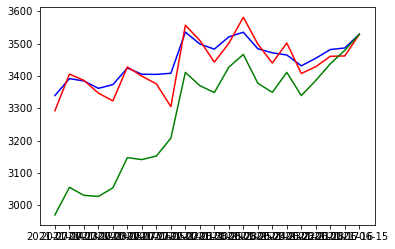

In [165]:
# 第步 绘出实际和未修正、修正指数

import matplotlib.pyplot as plt
plt.plot(sz50_index['close'],color='b') #.sort_values(ascending=False)
plt.plot(sz50_index['adj_oldindex'],color='r')
plt.plot(sz50_index['adj2_index'],color='g')
#plt.plot(sz50_index['unadj_index'])

In [125]:
3280*1.09/1.014

3525.838264299803

In [129]:
#3192*1.09/1.014
3528/3339

1.0566037735849056

In [ ]:
!conda install git
